In [ ]:
# Download the dataset !
!cp -r "/content/drive/MyDrive/AI Games/Route Availability Prediction/" /content/dataset
!ls /content/dataset/

CIWS  statuses.zip


In [ ]:
# Unzip the dataset !
%cd dataset
!unzip statuses.zip
%cd CIWS
!for file in $(ls); do unzip -o $file; done

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: VIL_merc/VIL-2021-01-06-04_00Z.npz  
  inflating: VIL_merc/VIL-2021-17-06-08_00Z.npz  
  inflating: VIL_merc/VIL-2021-13-04-02_00Z.npz  
  inflating: VIL_merc/VIL-2021-25-02-08_00Z.npz  
  inflating: VIL_merc/VIL-2021-26-03-20_00Z.npz  
  inflating: VIL_merc/VIL-2021-01-04-21_00Z.npz  
  inflating: VIL_merc/VIL-2021-08-04-14_00Z.npz  
  inflating: VIL_merc/VIL-2021-14-05-05_00Z.npz  
  inflating: VIL_merc/VIL-2021-02-05-09_00Z.npz  
  inflating: VIL_merc/VIL-2021-28-02-12_00Z.npz  
  inflating: VIL_merc/VIL-2021-30-01-09_00Z.npz  
  inflating: VIL_merc/VIL-2021-26-01-05_00Z.npz  
  inflating: VIL_merc/VIL-2021-02-05-19_00Z.npz  
  inflating: VIL_merc/VIL-2021-08-04-04_00Z.npz  
  inflating: VIL_merc/VIL-2021-14-05-15_00Z.npz  
  inflating: VIL_merc/VIL-2021-26-01-15_00Z.npz  
  inflating: VIL_merc/VIL-2021-28-02-02_00Z.npz  
  inflating: VIL_merc/VIL-2021-30-01-19_00Z.npz  
  inflating: VIL_merc/VIL-2021-09-0

In [ ]:
# Clean up the zips !
%cd /content/dataset
!rm *.zip
%cd CIWS
!rm *.zip

/content/dataset
/content/dataset/CIWS


In [ ]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%cd /content/dataset

/content/dataset


In [63]:
from functools import lru_cache
import os
from scipy import sparse
from math import sqrt
import numpy as np
from scipy import sparse

CWIS_FOLDER = "/content/dataset/CIWS/VIL_merc"

def decode_timestamp(timestamp):
  date, clock = timestamp.split(" ")
  hour, minutes, _, _ = clock.split(":")
  return f"{date}-{hour}_00Z"

@lru_cache(maxsize=70)
def get_weather_matrix(timestamp):
  filename = f"VIL-{decode_timestamp(timestamp)}.npz"
  full_filename = os.path.join(CWIS_FOLDER, filename)
  return sparse.load_npz(full_filename).toarray()

@lru_cache(maxsize=1)
def get_constant_matrix(size, c=1):
  _size = size + 1
  arr = np.zeros((_size, _size))

  for i in range(_size):
    arr[i:-i-1, i:-i-1] += c

  return arr[0:size, 0:size]

def get_weather(waypoint, timestamp, size=5):

  BOUNDARIES = [(21.9430, -67.5), (55.7765, -135)]

  try:
    matrix = get_weather_matrix(timestamp)
  except FileNotFoundError:
    arr = np.zeros((size, size))
    arr[0, 0] = -1
    return arr

  y_offset_perc = (waypoint[0] - BOUNDARIES[0][0]) / (BOUNDARIES[1][0] - BOUNDARIES[0][0])
  y_offset_perc = 1 - y_offset_perc
  y_offset = int(matrix.shape[0] * y_offset_perc)
  x_offset_perc = (waypoint[1] - BOUNDARIES[0][1]) / (BOUNDARIES[1][1] - BOUNDARIES[0][1])
  x_offset_perc = 1 - x_offset_perc
  x_offset = int(matrix.shape[1] * x_offset_perc)

  y0 = np.clip(y_offset - size, 0, matrix.shape[0])
  x0 = np.clip(x_offset - size, 0, matrix.shape[1])

  y1 = np.clip(y_offset + size, 0, matrix.shape[0])
  x1 = np.clip(x_offset + size, 0, matrix.shape[1])

  places = matrix[y0:y1, x0:x1]
  places *= get_constant_matrix(2 * size, c=0.25)

  min = np.min(places)
  max = np.max(places)

  return -1 if min == -1 else max

def get_weather_from_waypoints(waypoints, timestamp):
  MIN_DISTANCE = 0.3

  waypoints = list(map(np.array, waypoints))

  weathers = []
  for i in range(len(waypoints)):
    current_waypoint = waypoints[i]
    current_weather = get_weather(current_waypoint, timestamp)
    weathers.append(current_weather)

    if i >= len(waypoints) - 1:
      continue
    next_waypoint = waypoints[i + 1]

    distance_vector = (next_waypoint - current_waypoint) / np.linalg.norm(next_waypoint - current_waypoint)
    distance = np.linalg.norm(current_waypoint - next_waypoint)
    next_gen_waypoint = np.array(current_waypoint)
    while distance > MIN_DISTANCE:
      next_gen_waypoint = next_gen_waypoint + distance_vector * MIN_DISTANCE
      distance = np.linalg.norm(next_gen_waypoint - next_waypoint)
      weathers.append(get_weather(next_gen_waypoint, timestamp))

  min = np.min(weathers)
  max = np.max(weathers)

  return -1 if min == -1 else max

def get_hours(timestamp):
  return timestamp.split(":")[0]

In [64]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.preprocessing import OneHotEncoder

from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
import calendar
from sklearn.preprocessing import OneHotEncoder

unemployment = {2020:	[3.5,	3.5,	4.4,	14.7,	13.2,	11.0,	10.2,	8.4,	7.9,	6.9,	6.7,	6.7],
                2021:	[6.4,	6.2,	6.0, 6.0,	5.8,	5.9,	5.4,	5.2,	4.7,	4.6,	4.2,	3.9]}

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2019-01-01', end='2022-12-31').to_pydatetime()

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def year(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").year
    
def month(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").month

def day(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").day

def hour(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").hour

def minute(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").minute

def weekday(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").weekday()

def is_holiday(timestamp):
    d = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00")
    return datetime.datetime(d.year, d.month, d.day) in holidays

def last_month_day(timestamp): 
    d = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00")
    return calendar.monthrange(d.year, d.month)[1] == d.day

def protocol(route_id):
    for route in route_id.split(" "):
        if has_numbers(route):
          return route
    return route_id

def season(month):
    if month >= 3 and month < 6: return 'spring'
    elif month >= 6 and month < 9: return 'summer'
    elif month >= 9 and month < 12: return 'autumn'
    else: return 'winter'

def local_timestamp(timestamp, airport):
    d = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00")
    summer_2020_start = datetime.datetime(2020, 3, 10)
    summer_2020_finish = datetime.datetime(2020, 11, 1)
    summer_2021_start = datetime.datetime(2020, 3, 14)
    summer_2021_finish = datetime.datetime(2020, 11, 7)

    if (summer_2020_start <= d <= summer_2020_finish) or (summer_2021_start <= d <= summer_2021_finish):
      # if summer
      summer_offset = 1
    else:
      summer_offset = 0

    if airport == 'KDFW' or airport == 'KIAH':
      # -5 w lato -6 w zime
      offset = -6 + summer_offset
    else:
      # KSEA
      offset = -8 + summer_offset 
    return (d + datetime.timedelta(hours=offset)).strftime("%Y-%m-%d %H:%M:%S+00:00")

def working_hours(timestamp):
    return 10 <= datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").hour < 19

def high_traffic(timestamp):
    return 6 <= datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").hour < 24

def part_of_day(timestamp):
    h = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00").hour
    if 6 <= h < 10:
      return "morning"
    elif 10 <= h < 14:
      return "midday"
    elif 14 <= h < 18:
      return "afternoon"
    elif 18 <= h < 24:
      return "evening"
    else:
      return "night"

def long_holiday(timestamp):
    d = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00")
    d_scrapped = datetime.datetime(d.year, d.month, d.day)
    for holiday in holidays:
      diff = abs(holiday - d_scrapped)
      if diff < datetime.timedelta(days=3):
        return True
    return False

def unemployment_rate(timestamp):
    d = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00")
    return unemployment[d.year][d.month - 1]

def president(timestamp):
    d = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S+00:00")
    election = datetime.datetime(2021, 1, 20)
    if (d >= election ):
      return "Biden"
    else:
      return "Trump"

def waypoint_count(waypoints):
    return len(eval(waypoints))

def distance(waypoints):
    waypoints = eval(waypoints)
    dist = 0
    for i in range(len(waypoints) - 1):
        dist += ((waypoints[i][0] - waypoints[i+1][0])**2 + (waypoints[i][1] - waypoints[i+1][1])**2)**1/2
    return dist

def oh_encode(df, columns, full_df = None):
    oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    if full_df is None:
      encoded = pd.DataFrame(oh_encoder.fit_transform(df[columns]))
    else:
      oh_encoder.fit(full_df)
      encoded = oh_encoder.transform(df[columns])

    encoded.columns = oh_encoder.get_feature_names_out()
    df_left = df.drop(columns, axis=1)

    return pd.concat([df_left, encoded], axis=1)

In [65]:
import pandas as pd

def get_oils():
  oil = pd.read_csv("/content/dataset/BrentOilPrices.csv")

  days = []
  months = []
  years = []

  def parse_oil_time(t: str):
    MONTHS = {
      'Jan': 1,
      'Feb': 2,
      'Mar': 3,
      'Apr': 4,
      'May': 5,
      'Jun': 6,
      'Jul': 7,
      'Aug': 8,
      'Sep': 9,
      'Oct': 10,
      'Nov': 11,
      'Dec': 12
    }

    if "-" in t:
      day, month, year = t.split("-")
    else:
      t = t.replace(",", "")
      month, day, year = t.split(" ")
    days.append(int(day))
    months.append(int(MONTHS[month]))
    years.append(int(year if int(year) > 2000 else int(year) + 2000))

  oil["Date"].map(parse_oil_time)
  oil["Day"] = days
  oil["Month"] = months
  oil["Year"] = years
  oil = oil.drop(columns = ["Date"])
  return oil

get_oils().query('Day == 20 and Month == 1 and Year == 2020')

,Price,Day,Month,Year
8295,64.63,20,1,2020


In [69]:
import pandas as pd
from tqdm import tqdm

def get_dataset(dataset_path="/content/dataset", test_dataset=False, first_n=None, no_weather=False):
  oils = get_oils()
  def _process_oil(row):
    # print(row.)
    q = oils.query(f'Day == {row.day} and Month == {row.month} and Year == {row.year}')
    if q.shape[0] > 0:
      return q.iat[0, 0]
    else:
      return oils.query(f"Month == {row.month} and Year == {row.year}").Price.map(float).mean()

  TRAIN_OBSERVATIONS_PATH = f"{dataset_path}/train_observations.csv"
  TRAIN_AVAILABILTY_PATH = f"{dataset_path}/train_availability.csv"
  TEST_OBSERVATIONS_PATH = f"{dataset_path}/test_observations.csv"
  ROUTE_DEFINITIONS = f"{dataset_path}/route_definitions.csv"

  train_observations = pd.read_csv(TRAIN_OBSERVATIONS_PATH)
  test_observations = pd.read_csv(TEST_OBSERVATIONS_PATH)
  train_availability = pd.read_csv(TRAIN_AVAILABILTY_PATH)
  route_definitions = pd.read_csv(ROUTE_DEFINITIONS)

  if not test_dataset:
    dataset = pd.merge(train_observations, route_definitions, on='route_id', how='left')
  else:
    dataset = pd.merge(test_observations, route_definitions, on='route_id', how='left')

  if first_n is not None:
    dataset = dataset.head(n=first_n)
  
  if not test_dataset:
    dataset = dataset.drop_duplicates(subset=['route_id', 'timestamp'],keep="first")
    dataset = dataset.merge(train_availability, on="observation_id")

  dataset = dataset.drop_duplicates(subset=['observation_id'],keep="first")
  dataset = dataset.reset_index(drop=True)
  dataset['local_timestamp'] = dataset.apply(lambda row: local_timestamp(row.timestamp, row.airport), axis=1)
  dataset['year'] = dataset.apply(lambda row: year(row.local_timestamp), axis=1)
  dataset['season'] = dataset.apply(lambda row: season(month(row.local_timestamp)), axis=1)
  dataset['month'] = dataset.apply(lambda row: month(row.local_timestamp), axis=1)
  dataset['last_month_day'] = dataset.apply(lambda row: last_month_day(row.local_timestamp), axis=1)
  dataset['weekday'] = dataset.apply(lambda row: weekday(row.local_timestamp), axis=1)
  dataset['is_holiday'] = dataset.apply(lambda row: is_holiday(row.local_timestamp), axis=1)
  dataset['day'] = dataset.apply(lambda row: day(row.local_timestamp), axis=1)
  dataset['hour'] = dataset.apply(lambda row: hour(row.local_timestamp), axis=1)
  dataset['minute'] = dataset.apply(lambda row: minute(row.local_timestamp), axis=1)
  dataset['working_hours'] = dataset.apply(lambda row: working_hours(row.local_timestamp), axis=1)
  dataset['high_traffic'] = dataset.apply(lambda row: high_traffic(row.local_timestamp), axis=1)
  dataset['long_holiday'] = dataset.apply(lambda row: long_holiday(row.local_timestamp), axis=1)
  dataset['unemployment_rate'] = dataset.apply(lambda row: unemployment_rate(row.local_timestamp), axis=1)
  dataset['president'] = dataset.apply(lambda row: president(row.local_timestamp), axis=1)
  dataset['waypoint_count'] = dataset.apply(lambda row: waypoint_count(row.waypoints), axis=1)
  dataset['distance'] = dataset.apply(lambda row: distance(row.waypoints), axis=1)
  dataset['protocol'] = dataset.apply(lambda row: protocol(row.route_id), axis=1)

  dataset['oil_price'] = dataset.apply(_process_oil, axis=1)

  if not no_weather:
    dataset["weather"] = dataset.apply(lambda row: get_weather_from_waypoints(eval(row["waypoints"]), row["timestamp"]), axis=1)
  dataset = dataset.reset_index(drop=True)

  dataset = oh_encode(dataset, ['airport', 'season', 'is_holiday', 'last_month_day', \
    'protocol', 'route_type', 'working_hours', 'high_traffic', 'president', 'long_holiday'])

  dataset = dataset.drop(['route_id', 'timestamp', 'local_timestamp', 'waypoints'], axis=1)

  if not test_dataset:
    dataset["status"] = dataset["status"].eq('OPEN').mul(1)

  return dataset

In [ ]:
dataset = get_dataset()
dataset.head(n=20)

In [67]:
import pandas as pd

test_dataset = get_dataset(test_dataset=True)
test_dataset.head(n=20)

,observation_id,year,month,weekday,day,hour,minute,unemployment_rate,waypoint_count,distance,...,route_id_ZADON,route_type_ARRIVAL,route_type_DEPARTURE,working_hours_False,working_hours_True,high_traffic_False,high_traffic_True,president_Biden,long_holiday_False,long_holiday_True
0,1641,2021,11,2,3,10,5,4.2,2,9.913291,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
1,1646,2021,10,6,17,3,3,4.6,4,0.147293,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1663,2021,11,3,11,3,16,4.2,6,0.951610,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1664,2021,10,1,5,6,42,4.6,2,18.107898,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,1689,2021,11,3,25,5,58,4.2,2,0.745521,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
5,1698,2021,10,4,1,5,6,4.6,10,1.484923,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
6,1704,2021,10,4,1,5,13,4.6,6,0.951610,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7,1714,2021,10,5,30,19,3,4.6,2,0.170569,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
8,1732,2021,10,5,30,15,49,4.6,4,0.147293,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
9,1734,2021,10,0,25,3,2,4.6,4,0.147293,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [41]:
dataset.to_csv("dataset9.csv")
!cp dataset9.csv "/content/drive/MyDrive/AI Games/dataset9.csv"

In [56]:
test_dataset.to_csv("dataset-test9.csv")
!cp dataset-test9.csv "/content/drive/MyDrive/AI Games/dataset-test9.csv"

(7546,)
(8035,)


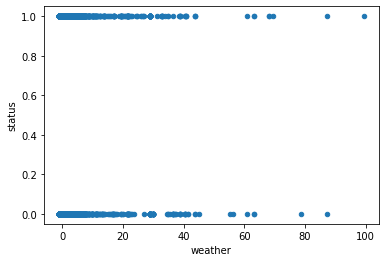

In [ ]:
dataset.plot(x="weather", y="status", kind="scatter")

print(dataset.query("weather >= 0 and status == 1")["weather"].shape)
print(dataset.query("weather >= 0 and status == 0")["weather"].shape)

In [ ]:
# Efforts for implementing NN

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from matplotlib import pyplot as plt

import pandas

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Data(Dataset):
  def __init__(self, dataset, size_perc, start_perc):
    self._dataset = dataset
    self._dataset["hour"] /= self._dataset["hour"].max()
    self._dataset["minute"] /= self._dataset["minute"].max()
    self._dataset["year"] /= self._dataset["year"].max()
    self._dataset["weekday"] /= self._dataset["weekday"].max()
    self._dataset["month"] /= self._dataset["month"].max()
    self._dataset["day"] /= self._dataset["day"].max()
    self._dataset["minute"] /= self._dataset["minute"].max()
    self._dataset.loc[self._dataset["weather"] > 0] /= self._dataset["weather"].max() 
    self._size_perc = size_perc
    self._start_perc = start_perc
  def __getitem__(self, index): 
      di = int(self._start_perc * self._dataset.shape[0])
      return self._dataset.iloc[di + index, 3:-2].to_numpy(), self._dataset.iloc[di + index, 2]
  def __len__(self):
      return int(self._dataset.shape[0] * self._size_perc)


dataset = pandas.read_csv("/content/dataset6.csv")
dataset = dataset.sample(frac=1).reset_index(drop=True)

data = Data(dataset, 0.8, 0)
loader = DataLoader(dataset=data, batch_size=32, shuffle=True)

data_test = Data(dataset, 0.2, 0.8)
loader_test = DataLoader(dataset=data_test, batch_size=1)

model = nn.Sequential(
        nn.Linear(88, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 2),
        nn.Sigmoid()
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

for epoch in range(1_000):
  print(f"Epoch {epoch}")
  for x, y in tqdm(loader):
    optimizer.zero_grad()
    pred_y = model(x.to(device).float())
    exp_y = torch.zeros((y.shape[0], 2))
    exp_y[y.argmax()] = 1
    loss = loss_fn(torch.squeeze(pred_y), exp_y.to(device).float())
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    good = 0
    all = 0
    for x, y in loader_test:
      #for x, y in zip(batch_x.to(device), batch_y.to(device)):
      pred_y = model(x.to(device).float())
      if torch.squeeze(pred_y.cpu().argmax()) == y:
        good += 1
      all += 1
    print(f"Acc: {good / all}")

Epoch 0


100%|██████████| 1045/1045 [00:09<00:00, 110.54it/s]


Acc: 0.4219535551831458
Epoch 1


100%|██████████| 1045/1045 [00:08<00:00, 129.69it/s]


Acc: 0.4285372276753651
Epoch 2


100%|██████████| 1045/1045 [00:08<00:00, 130.04it/s]


Acc: 0.4245870241800335
Epoch 3


100%|██████████| 1045/1045 [00:08<00:00, 130.45it/s]


Acc: 0.44266219774958104
Epoch 4


100%|██████████| 1045/1045 [00:07<00:00, 130.89it/s]


Acc: 0.4230308834091453
Epoch 5


100%|██████████| 1045/1045 [00:07<00:00, 131.39it/s]


Acc: 0.417165429734259
Epoch 6


100%|██████████| 1045/1045 [00:07<00:00, 130.70it/s]


Acc: 0.4243476179075892
Epoch 7


100%|██████████| 1045/1045 [00:08<00:00, 130.54it/s]


Acc: 0.44493655733780224
Epoch 8


100%|██████████| 1045/1045 [00:08<00:00, 128.35it/s]


Acc: 0.39514005266937996
Epoch 9


100%|██████████| 1045/1045 [00:08<00:00, 119.36it/s]


Acc: 0.42410821163514484
Epoch 10


100%|██████████| 1045/1045 [00:08<00:00, 129.59it/s]


Acc: 0.40543452238448646
Epoch 11


100%|██████████| 1045/1045 [00:08<00:00, 130.14it/s]


Acc: 0.4014843188891549
Epoch 12


100%|██████████| 1045/1045 [00:07<00:00, 131.14it/s]


Acc: 0.4053148192482643
Epoch 13


100%|██████████| 1045/1045 [00:08<00:00, 129.48it/s]


Acc: 0.40459660043093126
Epoch 14


100%|██████████| 1045/1045 [00:08<00:00, 130.32it/s]


Acc: 0.38316973904716306
Epoch 15


100%|██████████| 1045/1045 [00:07<00:00, 130.63it/s]


Acc: 0.40088580320804407
Epoch 16


100%|██████████| 1045/1045 [00:07<00:00, 131.99it/s]


Acc: 0.4243476179075892
Epoch 17


100%|██████████| 1045/1045 [00:08<00:00, 129.18it/s]


Acc: 0.4443380416566914
Epoch 18


100%|██████████| 1045/1045 [00:07<00:00, 132.16it/s]


Acc: 0.41249700742159445
Epoch 19


100%|██████████| 1045/1045 [00:08<00:00, 129.41it/s]


Acc: 0.4207565238209241
Epoch 20


100%|██████████| 1045/1045 [00:08<00:00, 129.80it/s]


Acc: 0.42051711754847976
Epoch 21


100%|██████████| 1045/1045 [00:08<00:00, 130.41it/s]


Acc: 0.4080679913813742
Epoch 22


100%|██████████| 1045/1045 [00:08<00:00, 130.00it/s]


Acc: 0.3963370840316016
Epoch 23


100%|██████████| 1045/1045 [00:08<00:00, 129.52it/s]


Acc: 0.5294469715106536
Epoch 24


100%|██████████| 1045/1045 [00:08<00:00, 129.14it/s]


Acc: 0.5440507541297582
Epoch 25


100%|██████████| 1045/1045 [00:08<00:00, 130.02it/s]


Acc: 0.5147234857553268
Epoch 26


100%|██████████| 1045/1045 [00:08<00:00, 129.63it/s]


Acc: 0.5198707206128801
Epoch 27


100%|██████████| 1045/1045 [00:07<00:00, 131.17it/s]


Acc: 0.5031122815417763
Epoch 28


100%|██████████| 1045/1045 [00:11<00:00, 89.14it/s]


Acc: 0.5234618146995451
Epoch 29


100%|██████████| 1045/1045 [00:08<00:00, 129.79it/s]


Acc: 0.5465645199904238
Epoch 30


100%|██████████| 1045/1045 [00:08<00:00, 129.83it/s]


Acc: 0.48324156092889636
Epoch 31


100%|██████████| 1045/1045 [00:07<00:00, 130.63it/s]


Acc: 0.5247785491979889
Epoch 32


100%|██████████| 1045/1045 [00:08<00:00, 128.67it/s]


Acc: 0.5227435958822121
Epoch 33


 95%|█████████▌| 997/1045 [00:07<00:00, 129.88it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, "model.pth")